[View in Colaboratory](https://colab.research.google.com/github/3catz/deeplearning_timeseries/blob/master/Temporal_Convolutional_Networks_with_Temporal_Attention_vs_XGBOost_for_Time_Series_Forecasting.ipynb)

# Temporal Convolutional Networks (sometimes with Attention) -- how much better are they an Auto ML XGBoost regression model?




In [1]:
!pip install keras-tcn
!pip install EMD-signal
!pip install auto_ml
!pip install pyhht
from auto_ml import Predictor
#from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model

from PyEMD import EEMD 
#pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score

import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint

#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer
from statsmodels.tsa.stattools import grangercausalitytests

    100% |████████████████████████████████| 163kB 7.2MB/s 
    100% |████████████████████████████████| 61kB 7.4MB/s 
    100% |████████████████████████████████| 112kB 6.1MB/s 
    100% |████████████████████████████████| 1.4MB 9.2MB/s 
  Running setup.py bdist_wheel for pathos ... - \ done
  Stored in directory: /root/.cache/pip/wheels/12/6b/3f/c9d2272bcd06caaf166988b27f72b7b08ab34ef211c8cbc4db
  Running setup.py bdist_wheel for ppft ... - \ done
  Stored in directory: /root/.cache/pip/wheels/6f/25/0d/a2099d51db6f2a7c6019599bd3b62795da3bf76a6a4eb0e615
  Running setup.py bdist_wheel for pox ... - done
  Stored in directory: /root/.cache/pip/wheels/16/f0/d1/d618f2d966cb9b219a87ef3eca40e369ef51462eb18ba9e8c5
  Running setup.py bdist_wheel for multiprocess ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/8b/36/e5/96614ab62baf927e9bc06889ea794a8e87552b84bb6bf65e3e
Successfully built pathos ppft pox multiprocess
    100% |████████████████████████████████| 71kB

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Utilities: series to supervised

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Loading Data 

In [6]:
from google.colab import files    
files.upload()




Saving SPIDR_windminly.csv to SPIDR_windminly.csv


{'SPIDR_windminly.csv': b'-2.346,-1.631,-1.817,-1.428,-0.752,0.544,0.539,-0.336,-2.398,-3.663,-3.36,-3.604,-3.594,0.857,-0.379,-1.56,-0.868,-1.091,-0.321,-0.111,0.748,0.646,0.207,-0.226,0.105,-0.296,0.489,1.046,1.002,1.481,0.567,0.818,1.684,0.821,1.035,0.584,2.145,1.585,0.071,1.31,2.206,1.309,1.342,1.315,1.408,1.544,1.625,-0.205,-4.861,-4.936,-4.295,-4.415,-4.463,0.562,3.855,3.083,3.605,4.195,2.68,2.662,2.733,3.845,3.61,3.92,3.138,3.4,3.62,0.541,-3.76,-4.03,-4.176,-3.051,-1.808,-0.902,1.084,-0.611,-2.44,-1.708,-1.937,-1.205,0.19,0.232,-1.411,-2.055,-0.605,-0.534,-1.045,-1.755,-1.116,-1.098,-0.878,1.181,1.588,1.35,1.332,1.738,2.25,1.76,-2.089,-5.296,-5.132,-4.919,-4.816,-4.09,-4.047,-3.901,-3.591,-3.477,-3.303,-1.807,-0.426,0.948,-0.394,-4.842,-4.808,-4.64,-4.895,-5.297,-5.042,-5.414,-5.568,-5.361,-5.453,-5.474,-4.361,-4.831,-5.016,-5.6,-5.025,-4.411,-5.162,-4.42,-4.754,-5.009,-4.817,-4.641,-4.772,-4.216,-3.541,-3.772,-2.976,-3.205,-3.689,-3.869,-2.342,-0.313,-0.223,-0.912,-0.341,0.265,

In [7]:
import numpy as np
data = np.genfromtxt("SPIDR_windminly.csv", delimiter = ","); data = np.asarray(data); data.shape

(10000,)

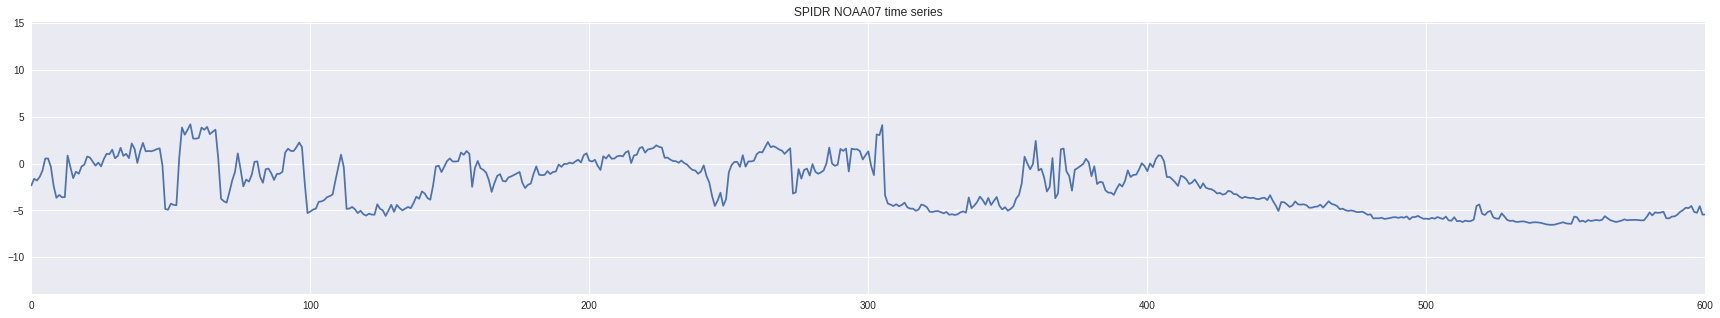

In [8]:
plt.figure(figsize=(30,5))
plt.plot(data)
plt.title("SPIDR NOAA07 time series")
plt.xlim([0,600])
plt.show()

In [9]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(10000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [11]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-1000]; out_sample = scaled_data[-1000:]
print(in_sample.shape)

(9000,)


In [0]:
in_sample = in_sample.reshape(-1,1)

# Hurst Exponents 

In [0]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):

    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    # Here it calculates the variances, but why it uses 
    # standard deviation and then make a root of it?
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [110]:
print(hurst(scaled_data)) #after imf5 they go up towards 1 which means the yare not noise they have clustered and direction
#that means taht before that the imfs are either white noise but maybe that means they are oscillating functions with mean  0. 

0.006212874342097481


In [13]:
from pandas import DataFrame, concat
raw_df = series_to_supervised(in_sample.reshape(-1,1), 10, 1, dropnan = True)
raw_df = np.array(raw_df)
trainX2 = raw_df[:,:-1]; trainY2 = raw_df[:,-1]; trainX2 = np.expand_dims(trainX2, axis = -1)
print(trainX2.shape, trainY2.shape)



(8990, 10, 1) (8990,)


# Network Architecture (Temporal Convolutional Networks) 

In [68]:
from tcn import tcn  #norm relu tends to work best with the SPIDR minly set

i = Input(batch_shape = (None, 10, 1))
o = tcn.TCN(nb_filters = 64, nb_stacks = 1, return_sequences = False, use_skip_connections = True, activation = "norm_relu", dropout_rate = 0.5)(i)
v = Activation("sigmoid")(o)
o = merge([o,v], mode = "mul")

o = Dense(1, activation='tanh', kernel_initializer = "glorot_uniform")(o)

m = Model(inputs = [i], outputs = o)
m.summary()
m.compile(optimizer = optimizers.Adam(lr = 1e-3, clipnorm = 0.1), loss = "mse", metrics = ["mae"])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
#checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-6, patience = 10, verbose = 1)


m.fit(trainX2, trainY2, epochs = 50, batch_size = 128, 
      callbacks = [reduce_lr, early], verbose = 1, 
      validation_split = 0.1, shuffle = False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
tcn_initial_conv (Conv1D)       (None, 10, 64)       128         input_4[0][0]                    
__________________________________________________________________________________________________
tcn_dilated_conv_1_tanh_s0 (Con (None, 10, 64)       8256        tcn_initial_conv[0][0]           
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 10, 64)       0           tcn_dilated_conv_1_tanh_s0[0][0] 
__________________________________________________________________________________________________
lambda_3 (

In [0]:
trainX_preds = m.predict(trainX2, batch_size = 1) 


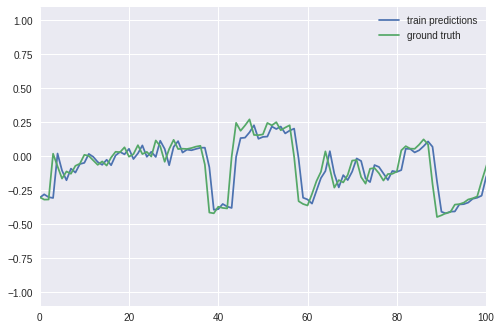

In [70]:
plt.plot(trainX_preds, label = "train predictions")
plt.plot(trainY2, label = "ground truth")
plt.legend()
plt.xlim([0,100])
plt.show()

In [72]:
print("Final R2 Score is: {}".format(r2_score(trainY2, trainX_preds)))
from sklearn.metrics import explained_variance_score, mean_squared_error
print("Final Explained Variance Score is: {}.".format(explained_variance_score(trainY2, trainX_preds)))


Final R2 Score is: 0.9463053987985041
Final Explained Variance Score is: 0.9463786541283994.


# Test the model on out of sample data. This is not an 1000 time step # into the future prediction, but a comparison of how well the last 10 observed values can be mapped to the next 1 value. Curve fitting, in other words.


In [54]:
outdf = series_to_supervised(out_sample.reshape(-1,1), 10, 1, dropnan = True)
outdf = np.array(outdf)
testX = outdf[:,:-1]; testY = outdf[:,-1]

testX = np.expand_dims(testX, axis = -1)
print(testX.shape, testY.shape)

(990, 10, 1) (990,)


In [73]:
test_preds = m.predict(testX, batch_size = 1) 
print("Final R2 Score is %s" % (r2_score(testY, test_preds)))
print("Final Explained Variance is %s" % (explained_variance_score(testY, test_preds)))

Final R2 Score is 0.9408061463401185
Final Explained Variance is 0.9431086880823406


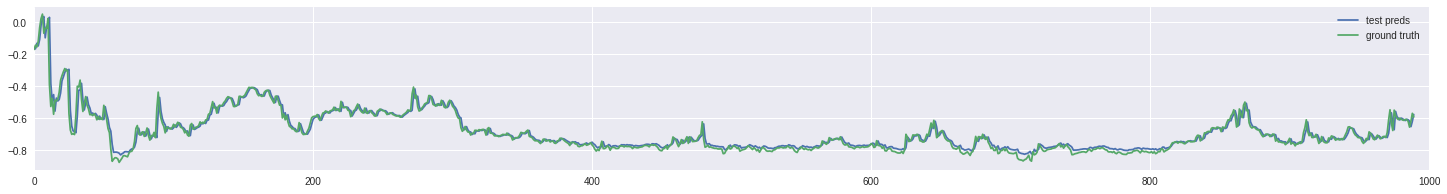

In [74]:
plt.subplots(figsize=(25,3))
plt.plot(test_preds, label = "test preds")
plt.plot(testY, label = "ground truth")
plt.legend()
plt.xlim([0,1000])
plt.show()

In [0]:
#Wilmotts index of agreement and Kling Gupta efficiency code

def index_agreement(s, o):
  ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
  return ia

def KGE(s, o):
  cc = np.corrcoef(o, s)[0,1]
  alpha = np.std(s)/np.std(o)
  beta = np.sum(s)/np.sum(o)
  kge = 1- np.sqrt( (cc-1)**2 + (alpha-1)**2 + (beta-1)**2 )
  return kge, cc, alpha, beta

In [77]:
#Kling Gupta efficiency
trainX_preds = np.squeeze(trainX_preds)
test_preds = np.squeeze(test_preds)
print(KGE(trainX_preds, trainY2))
print(KGE(test_preds, testY))


(0.9469605689230945, 0.9729639153296081, 0.9562269699846727, 1.012890043364336)
(0.9548901286767705, 0.9711489375589696, 0.966504523639099, 0.9910239345936867)


In [79]:
#Wilmott index of agreement 
print(index_agreement(trainX_preds, trainY2))
print(index_agreement(test_preds, testY))

0.9858248254030986
0.9844957962162052


# Using AutoML to test other types of regression models, eg XGBoost 

In [60]:
traindf = series_to_supervised(in_sample.reshape(-1,1), 10, 1, dropnan = True)
print(traindf.shape)

(8990, 11)


In [61]:
import pandas as pd
traindf = pd.DataFrame(traindf)

traindf.columns = [i for i in range(11)]


traindf.columns = traindf.columns.astype(str)

print(traindf.columns)
column_descriptions = {"10":"output"}

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)
ml_predictor.train(traindf, model_names=['XGBRegressor'])

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')
Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict 10
Started at:
2018-10-22 22:35:27
Finished training the pipeline!
Tot

In [80]:
testdf = series_to_supervised(out_sample.reshape(-1,1), 10, 1, dropnan = True)

testdf.columns = [i for i in range(11)]
testdf.columns = testdf.columns.astype(str)
print(testdf.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')


In [81]:
test_score = ml_predictor.score(testdf, testdf["10"])

None


***********************************************
Advanced scoring metrics for the trained regression model on this particular dataset:

Here is the overall RMSE for these predictions:
0.03573322158476016

Here is the average of the predictions:
-0.6733393100777058

Here is the average actual value on this validation set:
-0.6900254389295539

Here is the median prediction:
-0.7029200792312622

Here is the median actual value:
-0.7279781958587274

Here is the mean absolute error:
0.025906216874566252

Here is the median absolute error (robust to outliers):
0.02196021721166963

Here is the explained variance:
0.9400727835849145

Here is the R-squared value:
0.9233613017944013
Count of positive differences (prediction > actual):
792
Count of negative differences:
198
Average positive difference:
0.026620216079008902
Average negative difference:
-0.02305022005679564


***********************************************




<function matplotlib.pyplot.show>

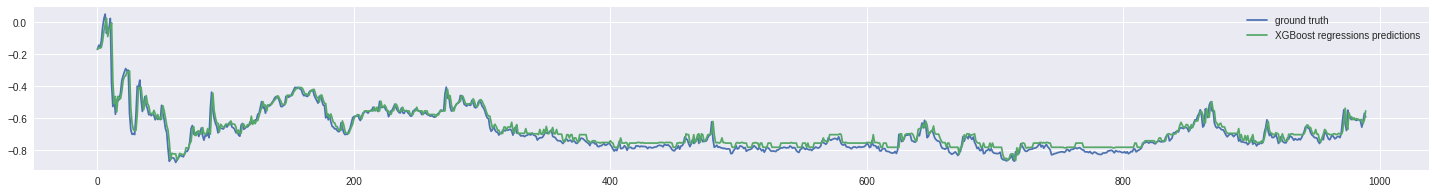

In [82]:
automl_preds = ml_predictor.predict(testdf)
plt.subplots(figsize=(25,3))
plt.plot(testY, label = "ground truth")
plt.plot(automl_preds, label = "XGBoost regressions predictions")
plt.legend()
plt.show


In [84]:
print(KGE(automl_preds, testY))
print(index_agreement(automl_preds, testY))


(0.9312709647581763, 0.9699445653532239, 0.9431177825915726, 0.9758180961013069)
0.9795120908362012
